### ESM-4: toy optimization problem.
- two generators, single load, single bus
- multiple time periods
- a storage device
- a discussion of storage dispatch, and the impact on the system
- (start of) a discussion about model VS reality juxtaposition

In [1]:
### Problem formulation
# generator 1: "gas" (CCGT), marginal cost 70 EUR/MWh, capacity 50 MW
# generator 2: "coal" (hard coal), marginal cost 40 EUR/MWh, capacity 100 MW
# load: "UA" (Ukraine), 120 MW
# multiple time steps
# storage device: "battery", capacity 100 MWh, charging efficiency 0.9, discharging efficiency 0.9

In [2]:
import pypsa
import numpy as np
import pandas as pd
import linopy
import matplotlib.pyplot as plt

### Create PyPSA network with components of the problem

In [3]:
n = pypsa.Network()

In [4]:
n.add("Bus", "UA", v_nom=380)
n.add(
    "Generator",
    "gas",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "coal",
    bus="UA",
    p_nom_extendable=False,
    marginal_cost=40,  # €/MWh
    p_nom=70,  # MW
)

In [5]:
n.snapshots = pd.date_range("2019-01-01", periods=5, freq="H")
load_series = pd.Series([30, 60, 80, 100, 70], index=n.snapshots)

In [6]:
n.add(
    "Load",
    "Ukraine",
    bus="UA",
    p_set=load_series,  # MW
)

In [ ]:
n.loads_t.p_set

## Solve with PyPSA optimize module w/o storage

In [8]:
# n.optimize.create_model()

In [ ]:
n.optimize(solver_name="glpk")

In [ ]:
n.objective

In [ ]:
n.generators_t.p

In [ ]:
# def plot_dispatch(n):
#     df = n.generators_t.p
#     colors = {"coal": "#8B4513", "gas": "#FFA500"}
#     df = df[["coal", "gas"]]
#     df.plot(kind="bar", stacked=True, width=0.9, color=[colors[c] for c in df.columns])
#     plt.xticks(np.arange(len(df.index)), df.index.strftime("%H:%M"))
#     plt.xticks(rotation=0)
#     plt.xlabel("Time")
#     plt.ylabel("MW")
#     plt.legend(loc="upper left")
#     plt.show()


# plot_dispatch(n)

### Retrieve electricity prices w/o storage

In [ ]:
n.model.dual

In [ ]:
prices = n.model.dual["Bus-nodal_balance"].values
series = pd.Series([item[0] for item in prices], index=n.snapshots.strftime("%H:%M"))
series.plot(marker="o", linestyle="-", color="black")

## Solve with PyPSA optimize module with storage device

### Add battery storage

In [ ]:
# see documentation: https://pypsa.readthedocs.io/en/latest/components.html#storage-unit

n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=20,  # MW
    max_hours=5,  # 20 MW * 5 hours = 100 MWh
    efficiency_store=0.9,
    efficiency_dispatch=0.9,
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

In [ ]:
# n.storage_units.T

### Solve the problem with storage and revise results

In [ ]:
# See documentation of storage unit equations: https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html#storage-unit-constraints
# ensure that the new variables and equations are added to the model
# n.optimize.create_model()

In [ ]:
n.optimize(solver_name="glpk")

In [ ]:
# Objective w/o storage unit 15600.0
n.objective

### Prepare dashboard

In [14]:
def dashboard(n):
    def plot_balance(n, ax):
        balance = (
            n.statistics.energy_balance(aggregate_time=False, aggregate_bus=False)
            .loc[:, :, "AC", "UA"]
            .droplevel(1)
        )
        colors = {"Load": "grey", "Generator": "blue", "StorageUnit": "black"}
        balance.T.plot(
            kind="bar",
            stacked=True,
            width=0.9,
            color=[colors[c] for c in balance.index],
            ax=ax,
        )
        ax.set_xticks(np.arange(len(balance.columns)))
        ax.set_xticklabels(balance.columns.strftime("%H:%M"), rotation=0)
        ax.set_ylabel("MW")
        ax.legend(loc="upper left")
        ax.set_title("Energy Balance")

    # Create a 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot 1: Energy Balance
    plot_balance(n, axs[0, 0])

    # Plot 2: Storage Unit Dispatch
    dispatch_time = n.storage_units_t.p.index.strftime("%H:%M")
    axs[0, 1].plot(
        dispatch_time,
        n.storage_units_t.p.values,
        marker="o",
        linestyle="-",
        color="black",
    )
    axs[0, 1].set_ylabel("MW")
    axs[0, 1].set_title("Storage Dispatch")

    # Plot 3: Storage Unit State of Charge
    state_of_charge_time = n.storage_units_t.state_of_charge.index.strftime("%H:%M")
    axs[1, 0].plot(
        state_of_charge_time,
        n.storage_units_t.state_of_charge.values,
        marker="o",
        linestyle="-",
        color="black",
    )
    axs[1, 0].set_ylabel("MWh")
    axs[1, 0].set_title("Storage State of Charge")

    # Plot 4: Prices
    prices = n.model.dual["Bus-nodal_balance"].values
    series = pd.Series(
        [item[0] for item in prices], index=n.snapshots.strftime("%H:%M")
    )
    axs[1, 1].plot(
        series.index, series.values, marker="o", linestyle="-", color="black"
    )
    axs[1, 1].set_title("Electricity price estimate")
    axs[1, 1].set_ylabel("€/MWh")

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
dashboard(n)

## Changing stuff and seeing what happens

### Scenario: unlimited storage, no losses

In [ ]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [ ]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=100,  # MW
    max_hours=10,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # n0 losses
    efficiency_dispatch=1,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

In [ ]:
n.optimize(solver_name="glpk")
dashboard(n)

In [ ]:
n.objective

### Scenario: 10 MW power x 10h duration storage, no losses

In [ ]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [ ]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=10,  # MW
    max_hours=10,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # n0 losses
    efficiency_dispatch=1,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

In [ ]:
n.optimize(solver_name="glpk")
dashboard(n)

### Scenario: 10 MW power x 1h duration storage, no losses

In [ ]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [ ]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=10,  # MW
    max_hours=1,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # n0 losses
    efficiency_dispatch=1,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

In [ ]:
n.optimize(solver_name="glpk")
dashboard(n)

### FInal Scenario: 20 MW power x 5h duration storage, losses 10% on discharge, 0% on charge

In [ ]:
if len(n.storage_units) != 0:
    n.remove("StorageUnit", "Battery")

In [12]:
n.add(
    "StorageUnit",
    "Battery",
    bus="UA",
    p_nom_extendable=False,
    p_nom=20,  # MW
    max_hours=5,  # 100 MW * 10 hours = 1000 MWh
    efficiency_store=1,  # 10% losses
    efficiency_dispatch=0.9,  # no losses
    state_of_charge_initial=0  # MWh
    # cyclic_state_of_charge=True,
)

/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/iegor/miniconda3/envs/pypsa/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-40g_wk_e.lp --output /tmp/linopy-solve-fdwoigub.sol
Reading problem data from '/tmp/linopy-problem-40g_wk_e.lp'...
60 rows, 25 columns, 89 non-zeros
307 lines were read
GLPK Simplex Optimizer 5.0
60 rows, 25 columns, 89 non-zeros
Preprocessing...
10 rows, 19 columns, 33 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.111e+00  ratio =  1.111e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 10
      0: obj =   2.380000000e+04 inf =   1.100e+02 (4)
      4: obj =   2.050000000e+04 inf =   0.000e+00 (0)
*    15: obj =   1.411000000e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (56572 bytes)
Writing basic solution to '/tmp/linopy-solve-fdwoigub.sol'...


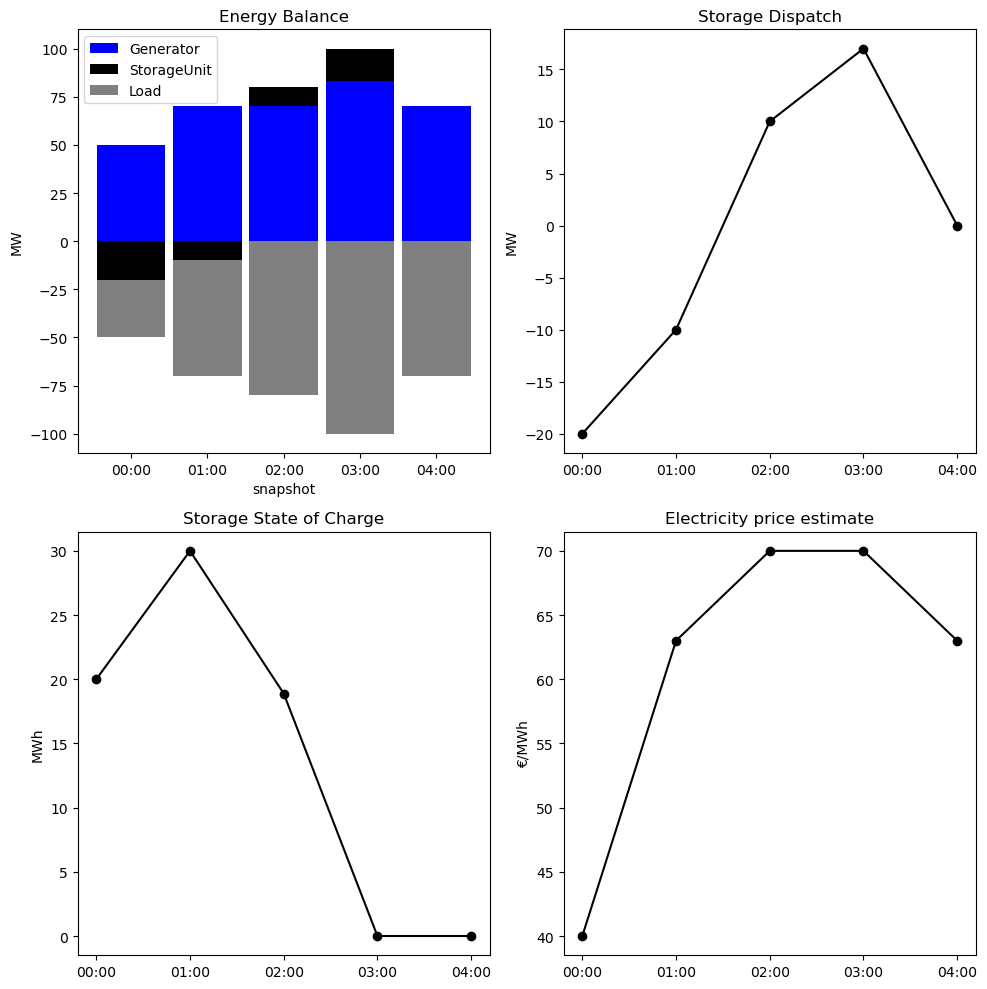

In [15]:
n.optimize(solver_name="glpk")
dashboard(n)

### Explain --- Why price in hour 01:00 is exactly 63 EUR/MWh?

In [ ]:
n.model.dual["Bus-nodal_balance"].values

In [ ]:
# Hints:
# n.model.dual['StorageUnit-fix-p_dispatch-upper']
# n.model.dual['StorageUnit-fix-p_store-upper']
# n.model.dual['StorageUnit-fix-state_of_charge-upper']
# n.model.dual["Bus-nodal_balance"]